## L5 - 1: Regression Model with TF DenseFeatures

### Instructions
- Build regression model to predict resting blood pressure (trestbps field in the dataset) using Tensorflow DenseFeatures
- Please include the age and sex features and create a TF cross feature(https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column) with them by binning the age field 
- Evaluate with common regression(MSE, MAE) and classification metrics(accuracy, F1, precision and recall across classes, AUC). No ROC or PR curve needed since this is a regression model that was converted to have a binary output and does not have the confidence in a given prediction.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
#from https://archive.ics.uci.edu/ml/datasets/Heart+Disease
swiss_dataset_path = "./data/heart_disease_data/processed_swiss.csv"
swiss_df = pd.read_csv(swiss_dataset_path).replace('?', np.nan)

In [2]:
column_list = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num_label']

In [3]:
cleveland_df = pd.read_csv("./data/heart_disease_data/processed.cleveland.txt",  names=column_list).replace('?', np.nan)

In [4]:
combined_heart_df = pd.concat([swiss_df, cleveland_df])

In [5]:
len(combined_heart_df)

426

### Solution
- Note that the dataset has only a three features and for the solution provided this does not include other important features that you can use to augment model performance. 

In [6]:
selected_features = ['sex',  'age', 'trestbps', 'thalach' ]
bp_df = combined_heart_df[selected_features].replace({1:"male", 0:"female"})

In [7]:
# how many rows with at least a single null value
sum(bp_df.apply(lambda x: sum(x.isnull().values), axis = 1)>0)

2

In [8]:
len(bp_df[bp_df['trestbps'].isnull()==True])

2

In [9]:
bp_df.head()

,sex,age,trestbps,thalach
0,male,32.0,95,127
1,male,34.0,115,154
2,male,35.0,NaN,130
3,male,36.0,110,125
4,female,38.0,105,166


In [10]:
#for simplicity will drop rows with null since predictor is null 
clean_df = bp_df.dropna()

In [11]:
clean_df.head()

,sex,age,trestbps,thalach
0,male,32.0,95,127
1,male,34.0,115,154
3,male,36.0,110,125
4,female,38.0,105,166
5,female,38.0,110,156


In [12]:
clean_df['trestbps'] = clean_df['trestbps'].astype(float)
clean_df['thalach'] = clean_df['thalach'].astype(float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
#adapted from https://www.tensorflow.org/tutorials/structured_data/feature_columns
def df_to_dataset(df, predictor,  batch_size=32):
    df = df.copy()
    labels = df.pop(predictor)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

In [14]:
#split 80 20 train test split - not ideal 
train_dataset = clean_df.sample(frac=0.8,random_state=0)
test_dataset = clean_df.drop(train_dataset.index)

In [15]:
PREDICTOR_FIELD = 'trestbps'
batch_size = 128
train_ds = df_to_dataset(train_dataset, PREDICTOR_FIELD, batch_size=batch_size)
test_ds = df_to_dataset(test_dataset, PREDICTOR_FIELD, batch_size=batch_size)

In [16]:
train_ds

<BatchDataset shapes: ({sex: (None,), age: (None,), thalach: (None,)}, (None,)), types: ({sex: tf.string, age: tf.float64, thalach: tf.float64}, tf.float64)>

In [17]:
# create TF numeric feature
tf_numeric_age_feature = tf.feature_column.numeric_column(key='age', default_value=0, dtype=tf.float64)

In [18]:
b_list = [ 0, 18, 25, 40, 55, 65, 80, 100]
#create TF bucket feature from numeric feature
tf_numeric_age_feature
tf_bucket_age_feature = tf.feature_column.bucketized_column(source_column=tf_numeric_age_feature, boundaries= b_list)

In [19]:
#using list b/c small number of unique values
gender_vocab = tf.feature_column.categorical_column_with_vocabulary_list(
      'sex', bp_df['sex'].unique())
gender_one_hot = tf.feature_column.indicator_column(gender_vocab)

In [20]:
# add cross features - use example from TF
crossed_age_gender_feature = tf.feature_column.crossed_column([tf_bucket_age_feature, gender_vocab], hash_bucket_size=1000)
tf_crossed_age_gender_feature = tf.feature_column.indicator_column(crossed_age_gender_feature)

In [21]:
feature_columns = [ tf_crossed_age_gender_feature, tf_bucket_age_feature, gender_one_hot ]
dense_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [22]:
# Use same architecture as example
def build_model(dense_feature_layer):
  model = tf.keras.Sequential([
    dense_feature_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [23]:
model = build_model(dense_feature_layer)

In [24]:
EPOCHS = 1000
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=50)     
history = model.fit(train_ds,   callbacks=[early_stop], epochs=EPOCHS,  verbose=1)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Train for 3 steps
Epoch 1/1000
3/3 [==============================] - 1s 462ms/step - loss: 17559.0210 - mae: 131.0518 - mse: 17540.1836
Epoch 2/1000
3/3 [==============================] - 0s 19ms/step - loss: 17558.1455 - mae: 130.8748 - mse: 17493.6660
Epoch 3/1000
3/3 [==============================] - 0s 18ms/step - loss: 17419.9611 - mae: 130.7169 - mse: 17452.5957
Epoch 4/1000
3/3 [==============================] - 0s 19ms/step - loss: 17403.7309 - mae: 130.5401 - mse: 17406.4434
Epoch 5/1000
3/3 [==============================] - 0s 20ms/step - loss: 17323.8268 - mae: 130.3299 - mse: 17351.7285
Epoch 6/1000
3/3 [=

3/3 [==============================] - 0s 19ms/step - loss: 2206.0317 - mae: 43.0963 - mse: 2219.6699
Epoch 60/1000
3/3 [==============================] - 0s 19ms/step - loss: 1952.8315 - mae: 40.1287 - mse: 1969.4794
Epoch 61/1000
3/3 [==============================] - 0s 20ms/step - loss: 1731.4132 - mae: 37.1135 - mse: 1736.6926
Epoch 62/1000
3/3 [==============================] - 0s 19ms/step - loss: 1535.6767 - mae: 34.1873 - mse: 1520.1963
Epoch 63/1000
3/3 [==============================] - 0s 17ms/step - loss: 1296.7368 - mae: 31.2394 - mse: 1322.0446
Epoch 64/1000
3/3 [==============================] - 0s 20ms/step - loss: 1160.6281 - mae: 28.5319 - mse: 1145.8502
Epoch 65/1000
3/3 [==============================] - 0s 20ms/step - loss: 981.0437 - mae: 25.8357 - mse: 986.3792
Epoch 66/1000
3/3 [==============================] - 0s 18ms/step - loss: 847.7989 - mae: 23.3384 - mse: 847.9606
Epoch 67/1000
3/3 [==============================] - 0s 19ms/step - loss: 735.0246 - mae: 

3/3 [==============================] - 0s 19ms/step - loss: 326.5434 - mae: 14.2014 - mse: 330.1596
Epoch 131/1000
3/3 [==============================] - 0s 18ms/step - loss: 331.1175 - mae: 14.1804 - mse: 330.1384
Epoch 132/1000
3/3 [==============================] - 0s 20ms/step - loss: 338.8468 - mae: 14.2663 - mse: 330.2950
Epoch 133/1000
3/3 [==============================] - 0s 18ms/step - loss: 330.5968 - mae: 14.2847 - mse: 332.9076
Epoch 134/1000
3/3 [==============================] - 0s 18ms/step - loss: 335.1311 - mae: 14.2693 - mse: 329.2528
Epoch 135/1000
3/3 [==============================] - 0s 19ms/step - loss: 338.5795 - mae: 14.2405 - mse: 331.3152
Epoch 136/1000
3/3 [==============================] - 0s 17ms/step - loss: 323.7025 - mae: 14.1891 - mse: 329.9955
Epoch 137/1000
3/3 [==============================] - 0s 19ms/step - loss: 326.8306 - mae: 14.1665 - mse: 328.8956
Epoch 138/1000
3/3 [==============================] - 0s 19ms/step - loss: 333.0150 - mae: 14.1

In [25]:
loss, mae, mse = model.evaluate(test_ds, verbose=2)
print("MAE:{}\nMSE:{}".format(mae, mse))

1/1 - 0s - loss: 349.6089 - mae: 14.8962 - mse: 349.6089
MAE:14.896234512329102
MSE:349.6088562011719


In [26]:
test_labels = test_dataset[PREDICTOR_FIELD].values

In [27]:
test_predictions = model.predict(test_ds).flatten()

In [28]:
model_pred_outputs = {
    "pred": test_predictions,
    "actual_value": test_labels,
}
model_output_df = pd.DataFrame(model_pred_outputs)

In [29]:
# Convert Regression Output to binary classification output
model_output_df.tail()

,pred,actual_value
41,139.423111,134.0
42,124.160782,170.0
43,131.868164,125.0
44,137.981552,120.0
45,131.868164,130.0


In [30]:
#convert to binary prediction for Brier score - resting bps above 130 
def convert_to_binary(df, pred_field, actual_field):
    # score is the field name we will use for predictions and is what Aequitas uses
    df['score'] = df[pred_field].apply(lambda x: 1 if x>=130 else 0 )
    # label_value is the field name we will use for the truth value and is what Aequitas uses
    df['label_value'] = df[actual_field].apply(lambda x: 1 if x>=130 else 0)
    return df

In [31]:
binary_df = convert_to_binary(model_output_df, 'pred', 'actual_value')
binary_df.head()

,pred,actual_value,score,label_value
0,137.981552,95.0,1,0
1,124.160782,115.0,0,0
2,124.160782,170.0,0,1
3,124.160782,160.0,0,1
4,137.981552,140.0,1,1


In [32]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

In [33]:
y_true = binary_df['label_value'].values 
y_pred = binary_df['score'].values

In [34]:
accuracy_score(y_true, y_pred)

0.5

In [35]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.37      0.38        19
           1       0.57      0.59      0.58        27

    accuracy                           0.50        46
   macro avg       0.48      0.48      0.48        46
weighted avg       0.50      0.50      0.50        46



In [36]:
roc_auc_score(y_true, y_pred)

0.48050682261208577

## L5 - 2: Demographic Bias Analysis

### Instructions
- Using the Compas dataset prepared by Aequitas, perform a Fairness Disparity Analysis on the under 25 Asian female reference group. See the documentation for reference -https://github.com/dssg/aequitas. In particular focus your analysis on fairness and disparity for FPR and where applicable try to leverage some of the visualizations Aequitas provides.

### Aequitas Compas Dataset
- Using 2016 dataset from ProPublica for automated criminal risk assessment algorithms and adapted from Aequitas notebook - https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb
- Preprocessed using this script --https://github.com/dssg/aequitas/blob/master/examples/compas_data_for_aequitas.py

The Aequitas Bias() class is used to calculate disparities between groups based on the crosstab returned by the Group() class get_crosstabs() method we used for preprocessing the dataset. 

### Instructions from Aequitas on Calculating Disparities across Reference Groups
(adapted from https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb)

Disparities are calculated as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for black defendants vis-a-vis whites is:$$Disparity_{FNR} =  \frac{FNR_{black}}{FNR_{white}}$$

Below, we use get_disparity_predefined_groups() which allows us to choose reference groups that clarify the output for the practitioner.

The Aequitas Bias() class includes two additional get disparity functions: get_disparity_major_group() and get_disparity_min_metric(), which automate base group selection based on sample majority (across each attribute) and minimum value for each calculated bias metric, respectively.

The get_disparity_predefined_groups() allows user to define a base group for each attribute.

Disparities Calculated Calcuated:
- True Positive Rate Disparity	'tpr_disprity'
- True Negative Rate	'tnr_disparity'
- False Omission Rate	'for_disparity'
- False Discovery Rate	'fdr_disparity'
- False Positive Rate	'fpr_disparity'
- False NegativeRate	'fnr_disparity'
- Negative Predictive Value	'npv_disparity'
- Precision Disparity	'precision_disparity'
- Predicted Positive Ratio$_k$ Disparity	'ppr_disparity'
- Predicted Positive Ratio$_g$ Disparity	'pprev_disparity'

**How do I interpret calculated disparity ratios?**
The calculated disparities from the dataframe returned by the Bias() class get_disparity_ methods are in relation to a reference group, which will always have a disparity of 1.0.

The differences in False Positive Rates, noted in the discussion of the Group() class above, are clarified using the disparity ratio (fpr_disparity). Black people are falsely identified as being high or medium risks 1.9 times the rate for white people.

As seen above, False Discovery Rates have much less disparity (fdr_disparity), or fraction of false postives over predicted positive in a group. As reference groups have disparity = 1 by design in Aequitas, the lower disparity is highlighted by the fdr_disparity value close to 1.0 (0.906) for the race attribute group 'African-American' when disparities are calculated using predefined base group 'Caucasian'. Note that COMPAS is calibrated to balance False Positive Rate and False Discovery Rates across groups.


**How does the selected reference group affect disparity calculations?**
Disparities calculated in the the Aequitas Bias() class based on the crosstab returned by the Group() class get_crosstabs() method can be derived using several different base gorups. In addition to using user-specified groups illustrated above, Aequitas can automate base group selection based on dataset characterisitcs:

Evaluating disparities calculated in relation to a different 'race' reference group
Changing even one attribute in the predefined groups will alter calculated disparities. When a different pre-defined group 'Hispanic' is used, we can see that Black people are 2.1 times more likely to be falsely identified as being high or medium risks as Hispanic people are (compared to 1.9 times more likely than white people), and even less likely to be falsely identified as low risk when compared to Hispanic people rather than white people.

In [37]:
# Use Aequitas Data that was transformed 
compas_df = pd.read_csv("./data/compas_for_aequitas.csv")

In [38]:
compas_df.head()

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


### Solution

### Dataset Preparation

In [39]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = compas_df[['sex', 'age_cat', 'race', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [3317]}


### Summarized Metric View

In [40]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,3317,sex,Female,591,804,288,195,609,303,498,897,1395,7214
1,1,binary 0/1,3317,sex,Male,2726,3093,994,1021,2072,1732,2753,3066,5819,7214
2,1,binary 0/1,3317,age_cat,25 - 45,1924,2185,741,706,1479,1183,1889,2220,4109,7214
3,1,binary 0/1,3317,age_cat,Greater than 45,394,1182,181,285,897,213,498,1078,1576,7214
4,1,binary 0/1,3317,age_cat,Less than 25,999,530,360,225,305,639,864,665,1529,7214
5,1,binary 0/1,3317,race,African-American,2174,1522,805,532,990,1369,1901,1795,3696,7214
6,1,binary 0/1,3317,race,Asian,8,24,2,3,21,6,9,23,32,7214
7,1,binary 0/1,3317,race,Caucasian,854,1600,349,461,1139,505,966,1488,2454,7214
8,1,binary 0/1,3317,race,Hispanic,190,447,87,129,318,103,232,405,637,7214
9,1,binary 0/1,3317,race,Native American,12,6,3,1,5,9,10,8,18,7214


In [41]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,sex,Female,0.61,0.68,0.24,0.49,0.32,0.39,0.76,0.51,0.18,0.42,0.36
1,sex,Male,0.63,0.68,0.33,0.36,0.32,0.37,0.67,0.64,0.82,0.47,0.47
2,age_cat,25 - 45,0.63,0.67,0.32,0.39,0.33,0.37,0.68,0.61,0.58,0.47,0.46
3,age_cat,Greater than 45,0.43,0.83,0.24,0.46,0.17,0.57,0.76,0.54,0.12,0.25,0.32
4,age_cat,Less than 25,0.74,0.46,0.42,0.36,0.54,0.26,0.58,0.64,0.30,0.65,0.57
5,race,African-American,0.72,0.55,0.35,0.37,0.45,0.28,0.65,0.63,0.66,0.59,0.51
6,race,Asian,0.67,0.91,0.12,0.25,0.09,0.33,0.88,0.75,0.00,0.25,0.28
7,race,Caucasian,0.52,0.77,0.29,0.41,0.23,0.48,0.71,0.59,0.26,0.35,0.39
8,race,Hispanic,0.44,0.79,0.29,0.46,0.21,0.56,0.71,0.54,0.06,0.30,0.36
9,race,Native American,0.90,0.62,0.17,0.25,0.38,0.10,0.83,0.75,0.00,0.67,0.56


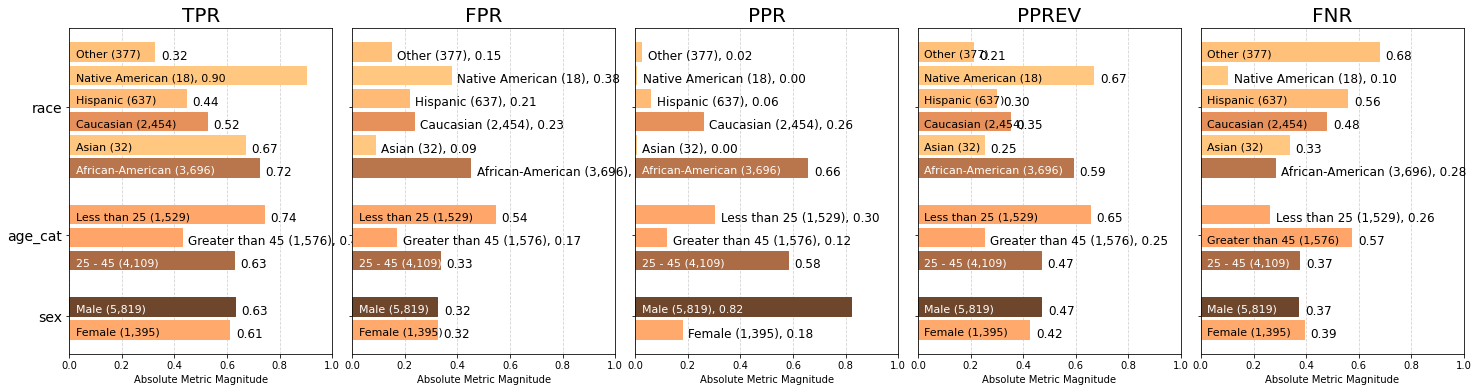

In [42]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'ppr', 'pprev', 'fnr'], ncols=5)

### Add Reference Group

In [43]:
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Asian', 'sex':'Female', 'age_cat':'Less than 25'},
                    alpha=0.05, 
                    check_significance=False)

f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


### FPR Analysis

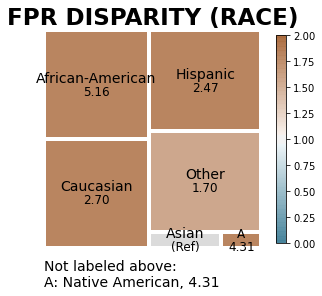

In [44]:
 fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='race')

African Americans are over 5x more likely to be falsely identified as well as Hispanic and Caucasian have over 2x more likely to be falsely identified than Asian.

### Absolute Value Fairness Determination
- Red = False/Not Fair
- Green = True/Fair

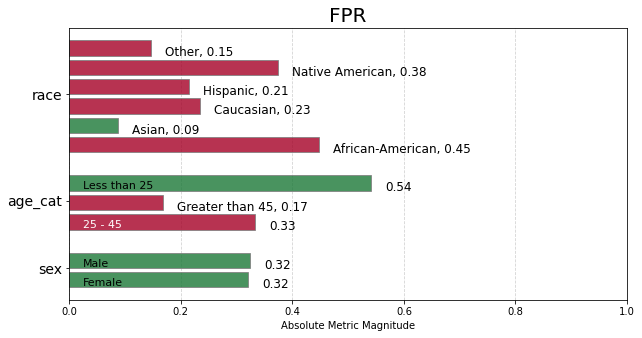

In [45]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

## L5 - 3: Uncertainty Estimation Model

### Instructions
- Given the Swiss heart disease dataset we have been working with, create an uncertainty estimation model that accounts for Epistemic Uncertainty as well. Provide the mean and standard deviation outputs.
- https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html

In [46]:
import tensorflow_probability as tfp

In [47]:
'''
Adapted from Tensorflow Probability Regression tutorial  https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb    
'''
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2*n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
            tfp.distributions.Normal(loc=t[..., :n],
                                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])


def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
            tfp.distributions.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])


In [48]:
def build_seq_prob_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
           tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),        
        tfp.layers.DistributionLambda(            
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                            scale=1e-3 + tf.math.softplus(0.1 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_prob_model(train_ds,   feature_layer,  epochs=5, loss_metric='mse'):
    model = build_seq_prob_model(feature_layer)
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    loss = negloglik
    model.compile(optimizer='adam', loss=loss, metrics=[loss_metric])
    history = model.fit(train_ds, 
                        epochs=epochs)
    return model, history

In [49]:
prob_model, history = build_prob_model(train_ds, dense_feature_layer,  epochs=1000)

Train for 3 steps
Epoch 1/1000
3/3 [==============================] - 2s 616ms/step - loss: 22700.7298 - mse: 17729.5215
Epoch 2/1000
3/3 [==============================] - 0s 20ms/step - loss: 15823.9386 - mse: 17572.4160
Epoch 3/1000
3/3 [==============================] - 0s 19ms/step - loss: 20491.6932 - mse: 17943.3457
Epoch 4/1000
3/3 [==============================] - 0s 22ms/step - loss: 18728.6090 - mse: 17512.6895
Epoch 5/1000
3/3 [==============================] - 0s 21ms/step - loss: 18236.1663 - mse: 17422.8555
Epoch 6/1000
3/3 [==============================] - 0s 21ms/step - loss: 16773.6381 - mse: 17276.8750
Epoch 7/1000
3/3 [==============================] - 0s 24ms/step - loss: 18540.6252 - mse: 17371.6738
Epoch 8/1000
3/3 [==============================] - 0s 20ms/step - loss: 20451.8812 - mse: 17267.3047
Epoch 9/1000
3/3 [==============================] - 0s 19ms/step - loss: 21347.6515 - mse: 17461.0898
Epoch 10/1000
3/3 [==============================] - 0s 22ms/st

3/3 [==============================] - 0s 21ms/step - loss: 4190.6464 - mse: 15228.3232
Epoch 81/1000
3/3 [==============================] - 0s 23ms/step - loss: 6459.4339 - mse: 14291.7109
Epoch 82/1000
3/3 [==============================] - 0s 21ms/step - loss: 4514.9671 - mse: 14124.3809
Epoch 83/1000
3/3 [==============================] - 0s 23ms/step - loss: 6488.9945 - mse: 16006.6182
Epoch 84/1000
3/3 [==============================] - 0s 21ms/step - loss: 4442.3570 - mse: 15447.4531
Epoch 85/1000
3/3 [==============================] - 0s 22ms/step - loss: 3803.5512 - mse: 14920.9473
Epoch 86/1000
3/3 [==============================] - 0s 22ms/step - loss: 6858.8902 - mse: 15720.5176
Epoch 87/1000
3/3 [==============================] - 0s 22ms/step - loss: 15780.3060 - mse: 15073.9023
Epoch 88/1000
3/3 [==============================] - 0s 22ms/step - loss: 4421.4393 - mse: 12841.1299
Epoch 89/1000
3/3 [==============================] - 0s 23ms/step - loss: 3737.5305 - mse: 1445

3/3 [==============================] - 0s 22ms/step - loss: 393.5706 - mse: 8579.9238
Epoch 161/1000
3/3 [==============================] - 0s 22ms/step - loss: 388.8061 - mse: 10320.0801
Epoch 162/1000
3/3 [==============================] - 0s 21ms/step - loss: 495.4794 - mse: 9521.6475
Epoch 163/1000
3/3 [==============================] - 0s 24ms/step - loss: 218.5576 - mse: 8652.9805
Epoch 164/1000
3/3 [==============================] - 0s 21ms/step - loss: 1025.3449 - mse: 8809.5371
Epoch 165/1000
3/3 [==============================] - 0s 23ms/step - loss: 178.8523 - mse: 5093.2983
Epoch 166/1000
3/3 [==============================] - 0s 22ms/step - loss: 251.5348 - mse: 8097.4556
Epoch 167/1000
3/3 [==============================] - 0s 22ms/step - loss: 233.9373 - mse: 9334.7109
Epoch 168/1000
3/3 [==============================] - 0s 22ms/step - loss: 478.6223 - mse: 10507.8682
Epoch 169/1000
3/3 [==============================] - 0s 22ms/step - loss: 465.6337 - mse: 8064.7715
Ep

3/3 [==============================] - 0s 21ms/step - loss: 176.0193 - mse: 6050.0620
Epoch 242/1000
3/3 [==============================] - 0s 22ms/step - loss: 222.4934 - mse: 4311.9204
Epoch 243/1000
3/3 [==============================] - 0s 23ms/step - loss: 1658.6708 - mse: 6092.4053
Epoch 244/1000
3/3 [==============================] - 0s 23ms/step - loss: 145.1641 - mse: 6707.4253
Epoch 245/1000
3/3 [==============================] - 0s 21ms/step - loss: 234.1158 - mse: 5940.2891
Epoch 246/1000
3/3 [==============================] - 0s 23ms/step - loss: 150.1465 - mse: 7088.7490
Epoch 247/1000
3/3 [==============================] - 0s 22ms/step - loss: 183.3022 - mse: 4485.0820
Epoch 248/1000
3/3 [==============================] - 0s 21ms/step - loss: 94.9871 - mse: 2315.2559
Epoch 249/1000
3/3 [==============================] - 0s 21ms/step - loss: 134.6653 - mse: 7163.9570
Epoch 250/1000
3/3 [==============================] - 0s 23ms/step - loss: 548.2435 - mse: 3516.7505
Epoch

3/3 [==============================] - 0s 22ms/step - loss: 206.6521 - mse: 4781.2300
Epoch 323/1000
3/3 [==============================] - 0s 21ms/step - loss: 646.2071 - mse: 8982.5166
Epoch 324/1000
3/3 [==============================] - 0s 23ms/step - loss: 31.9110 - mse: 3504.0029
Epoch 325/1000
3/3 [==============================] - 0s 23ms/step - loss: 96.0432 - mse: 5178.4663
Epoch 326/1000
3/3 [==============================] - 0s 22ms/step - loss: 44.5900 - mse: 2563.5667
Epoch 327/1000
3/3 [==============================] - 0s 25ms/step - loss: 36.4642 - mse: 2220.4272
Epoch 328/1000
3/3 [==============================] - 0s 23ms/step - loss: 26.8854 - mse: 2452.7397
Epoch 329/1000
3/3 [==============================] - 0s 22ms/step - loss: 23.9214 - mse: 2945.6426
Epoch 330/1000
3/3 [==============================] - 0s 21ms/step - loss: 83.3794 - mse: 2631.4861
Epoch 331/1000
3/3 [==============================] - 0s 24ms/step - loss: 35.0833 - mse: 2324.6748
Epoch 332/100

Epoch 404/1000
3/3 [==============================] - 0s 20ms/step - loss: 20.1545 - mse: 1747.1766
Epoch 405/1000
3/3 [==============================] - 0s 20ms/step - loss: 35.0718 - mse: 1368.3689
Epoch 406/1000
3/3 [==============================] - 0s 21ms/step - loss: 63.7441 - mse: 4503.0835
Epoch 407/1000
3/3 [==============================] - 0s 19ms/step - loss: 38.0051 - mse: 2512.0967
Epoch 408/1000
3/3 [==============================] - 0s 21ms/step - loss: 38.2589 - mse: 4821.6440
Epoch 409/1000
3/3 [==============================] - 0s 22ms/step - loss: 24.4510 - mse: 1862.5886
Epoch 410/1000
3/3 [==============================] - 0s 21ms/step - loss: 35.7330 - mse: 2509.6487
Epoch 411/1000
3/3 [==============================] - 0s 23ms/step - loss: 34.0629 - mse: 3428.8447
Epoch 412/1000
3/3 [==============================] - 0s 20ms/step - loss: 15.3984 - mse: 2080.2097
Epoch 413/1000
3/3 [==============================] - 0s 22ms/step - loss: 27.0628 - mse: 1758.7222


Epoch 486/1000
3/3 [==============================] - 0s 20ms/step - loss: 32.7912 - mse: 1849.7532
Epoch 487/1000
3/3 [==============================] - 0s 21ms/step - loss: 19.8840 - mse: 1962.8551
Epoch 488/1000
3/3 [==============================] - 0s 22ms/step - loss: 48.0116 - mse: 2703.1836
Epoch 489/1000
3/3 [==============================] - 0s 22ms/step - loss: 38.3333 - mse: 4191.8125
Epoch 490/1000
3/3 [==============================] - 0s 21ms/step - loss: 15.9929 - mse: 1279.6285
Epoch 491/1000
3/3 [==============================] - 0s 21ms/step - loss: 65.0757 - mse: 4882.1729
Epoch 492/1000
3/3 [==============================] - 0s 21ms/step - loss: 51.1098 - mse: 2703.9121
Epoch 493/1000
3/3 [==============================] - 0s 22ms/step - loss: 28.9456 - mse: 3852.2717
Epoch 494/1000
3/3 [==============================] - 0s 21ms/step - loss: 35.4874 - mse: 3799.7935
Epoch 495/1000
3/3 [==============================] - 0s 24ms/step - loss: 305.9338 - mse: 1152.8423

3/3 [==============================] - 0s 22ms/step - loss: 15.0248 - mse: 980.8486
Epoch 569/1000
3/3 [==============================] - 0s 22ms/step - loss: 12.6141 - mse: 818.3140
Epoch 570/1000
3/3 [==============================] - 0s 22ms/step - loss: 49.2463 - mse: 3045.7405
Epoch 571/1000
3/3 [==============================] - 0s 22ms/step - loss: 53.4336 - mse: 1663.7616
Epoch 572/1000
3/3 [==============================] - 0s 22ms/step - loss: 25.8255 - mse: 1987.8971
Epoch 573/1000
3/3 [==============================] - 0s 21ms/step - loss: 22.6174 - mse: 1225.2032
Epoch 574/1000
3/3 [==============================] - 0s 21ms/step - loss: 32.3800 - mse: 1551.4670
Epoch 575/1000
3/3 [==============================] - 0s 21ms/step - loss: 12.9227 - mse: 981.0043
Epoch 576/1000
3/3 [==============================] - 0s 22ms/step - loss: 35.6472 - mse: 2330.7036
Epoch 577/1000
3/3 [==============================] - 0s 21ms/step - loss: 15.3369 - mse: 1965.7908
Epoch 578/1000
3/3

3/3 [==============================] - 0s 21ms/step - loss: 72.8178 - mse: 2779.2009
Epoch 651/1000
3/3 [==============================] - 0s 20ms/step - loss: 25.9623 - mse: 1512.1807
Epoch 652/1000
3/3 [==============================] - 0s 21ms/step - loss: 27.2551 - mse: 2057.5764
Epoch 653/1000
3/3 [==============================] - 0s 20ms/step - loss: 21.1527 - mse: 1810.6222
Epoch 654/1000
3/3 [==============================] - 0s 21ms/step - loss: 12.3003 - mse: 1761.9192
Epoch 655/1000
3/3 [==============================] - 0s 21ms/step - loss: 10.2678 - mse: 893.6886
Epoch 656/1000
3/3 [==============================] - 0s 19ms/step - loss: 24.0776 - mse: 1727.8357
Epoch 657/1000
3/3 [==============================] - 0s 19ms/step - loss: 15.4557 - mse: 1035.8455
Epoch 658/1000
3/3 [==============================] - 0s 22ms/step - loss: 6.9517 - mse: 693.3740
Epoch 659/1000
3/3 [==============================] - 0s 22ms/step - loss: 21.1068 - mse: 2380.5063
Epoch 660/1000
3/3

3/3 [==============================] - 0s 21ms/step - loss: 9.4583 - mse: 661.6469
Epoch 733/1000
3/3 [==============================] - 0s 22ms/step - loss: 13.8152 - mse: 979.1255
Epoch 734/1000
3/3 [==============================] - 0s 21ms/step - loss: 16.5165 - mse: 1947.3453
Epoch 735/1000
3/3 [==============================] - 0s 22ms/step - loss: 7.2502 - mse: 581.1517
Epoch 736/1000
3/3 [==============================] - 0s 22ms/step - loss: 16.1448 - mse: 1556.4491
Epoch 737/1000
3/3 [==============================] - 0s 22ms/step - loss: 22.3246 - mse: 2694.6978
Epoch 738/1000
3/3 [==============================] - 0s 20ms/step - loss: 25.8223 - mse: 3578.6653
Epoch 739/1000
3/3 [==============================] - 0s 21ms/step - loss: 6.4035 - mse: 569.6697
Epoch 740/1000
3/3 [==============================] - 0s 21ms/step - loss: 7.6379 - mse: 732.7015
Epoch 741/1000
3/3 [==============================] - 0s 23ms/step - loss: 10.1162 - mse: 923.1428
Epoch 742/1000
3/3 [=====

3/3 [==============================] - 0s 21ms/step - loss: 64.6433 - mse: 2108.8574
Epoch 815/1000
3/3 [==============================] - 0s 21ms/step - loss: 11.6462 - mse: 1401.2649
Epoch 816/1000
3/3 [==============================] - 0s 22ms/step - loss: 11.0914 - mse: 1399.2373
Epoch 817/1000
3/3 [==============================] - 0s 22ms/step - loss: 8.1380 - mse: 1180.4381
Epoch 818/1000
3/3 [==============================] - 0s 21ms/step - loss: 7.8442 - mse: 988.4061
Epoch 819/1000
3/3 [==============================] - 0s 22ms/step - loss: 13.2738 - mse: 1576.6056
Epoch 820/1000
3/3 [==============================] - 0s 22ms/step - loss: 6.9725 - mse: 709.9931
Epoch 821/1000
3/3 [==============================] - 0s 22ms/step - loss: 21.0961 - mse: 3088.6699
Epoch 822/1000
3/3 [==============================] - 0s 22ms/step - loss: 17.2456 - mse: 1953.4689
Epoch 823/1000
3/3 [==============================] - 0s 21ms/step - loss: 8.3296 - mse: 962.6133
Epoch 824/1000
3/3 [==

3/3 [==============================] - 0s 23ms/step - loss: 19.6416 - mse: 1037.8068
Epoch 897/1000
3/3 [==============================] - 0s 21ms/step - loss: 11.4102 - mse: 2054.3528
Epoch 898/1000
3/3 [==============================] - 0s 21ms/step - loss: 10.6992 - mse: 1095.2333
Epoch 899/1000
3/3 [==============================] - 0s 35ms/step - loss: 21.8143 - mse: 4942.8022
Epoch 900/1000
3/3 [==============================] - 0s 28ms/step - loss: 12.3974 - mse: 759.6701
Epoch 901/1000
3/3 [==============================] - 0s 30ms/step - loss: 13.7443 - mse: 1574.8223
Epoch 902/1000
3/3 [==============================] - 0s 32ms/step - loss: 14.5371 - mse: 780.7130
Epoch 903/1000
3/3 [==============================] - 0s 30ms/step - loss: 7.7369 - mse: 610.1833
Epoch 904/1000
3/3 [==============================] - 0s 31ms/step - loss: 5.9853 - mse: 605.9449
Epoch 905/1000
3/3 [==============================] - 0s 31ms/step - loss: 8.2574 - mse: 878.0739
Epoch 906/1000
3/3 [===

3/3 [==============================] - 0s 22ms/step - loss: 9.6173 - mse: 870.1969
Epoch 979/1000
3/3 [==============================] - 0s 21ms/step - loss: 1465.8039 - mse: 1392.0675
Epoch 980/1000
3/3 [==============================] - 0s 22ms/step - loss: 15.7976 - mse: 1012.1723
Epoch 981/1000
3/3 [==============================] - 0s 21ms/step - loss: 5.8779 - mse: 585.5406
Epoch 982/1000
3/3 [==============================] - 0s 20ms/step - loss: 9.6215 - mse: 982.4510
Epoch 983/1000
3/3 [==============================] - 0s 21ms/step - loss: 18.7200 - mse: 953.0276
Epoch 984/1000
3/3 [==============================] - 0s 21ms/step - loss: 6.5985 - mse: 660.8774
Epoch 985/1000
3/3 [==============================] - 0s 21ms/step - loss: 9.0044 - mse: 933.2582
Epoch 986/1000
3/3 [==============================] - 0s 22ms/step - loss: 13.7214 - mse: 1814.8975
Epoch 987/1000
3/3 [==============================] - 0s 21ms/step - loss: 11.0406 - mse: 823.6606
Epoch 988/1000
3/3 [=====

In [50]:
feature_list = ['sex', 'age', 'thalach']
x_tst = dict(test_dataset[feature_list])
yhat = prob_model(x_tst)
prob_preds = prob_model.predict(test_ds)
m = yhat.mean()
s = yhat.stddev()

In [51]:
prob_outputs = {
    "pred": prob_preds.flatten(),
     "actual_value": test_dataset['trestbps'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [52]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,171.974747,95.0,129.968460,10.840653
1,167.345840,115.0,129.968460,10.840653
2,165.984207,170.0,131.299423,11.063090
3,164.962631,160.0,131.342010,11.231108
4,166.224243,140.0,131.299423,11.063090


In [53]:
yhats = [prob_model(x_tst) for _ in range(10)]

In [54]:
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    print("Mean distributions sampled:{}".format(m))
    print("Standard deviation distributions sampled:{}".format(s))


Mean distributions sampled:[92.0115   92.0115   93.3373   94.33059  93.3373   94.47065  96.792244
 94.47065  93.3373   92.0115   96.792244 93.3373   93.3373   93.3373
 94.33059  92.0115   92.0115   91.10446  91.10446  96.792244 92.0115
 94.47065  91.10446  93.3373   94.47065  92.0115   94.33059  92.0115
 91.10446  91.10446  91.10446  93.3373   92.0115   93.3373   91.10446
 94.33059  93.3373   93.3373   92.0115   93.3373   92.0115   93.3373
 93.3373   93.3373   93.3373   94.47065 ]
Standard deviation distributions sampled:[10.819591 10.819591 10.939765 11.105456 10.939765 11.087395 11.453257
 11.087395 10.939765 10.819591 11.453257 10.939765 10.939765 10.939765
 11.105456 10.819591 10.819591 10.604345 10.604345 11.453257 10.819591
 11.087395 10.604345 10.939765 11.087395 10.819591 11.105456 10.819591
 10.604345 10.604345 10.604345 10.939765 10.819591 10.939765 10.604345
 11.105456 10.939765 10.939765 10.819591 10.939765 10.819591 10.939765
 10.939765 10.939765 10.939765 11.087395]
Mean 